## Предсказание входящего потока рабочей нагрузки.

В рамках задачи нам необходимо исследовать бизнес-контекст и содержание временного ряда, отражающего количество задач среднего уровня, поступающих в обработку.  

В ТЗ указаны стоимость человеко-часов для сотрудников трех уровней и логика распределения нагрузки по ним:
- при недостаточной нагрузке на специалистов средней квалификации, они направляются на решение задач низкого уровня квалификации 
- при избыточной загрузке к решению задач среднего уровня привлекаются сотрудники с наивысшей категорией  

Таким образом, при недостаточно точном прогнозировании нагрузки мы будем платить штраф в альтернативных издержках:  
- при заниженном прогнозе за каждый человеко-час мы переплачиваем 2 у.е. (5 у.е. за высоковалифицированного сотрудника вместо 3 у.е. за среднеквалифицированного)
- при завышенном прогнозе за каждый человеко-час переплачиваем 1 у.е. (аналогично 3 у.е. вместо 2 у.е. на задачах низкой сложности)  

Исходя из этого мы можем сформулировать метрику, отражающую издержки, сопутствующие следованию прогнозу модели:  
$$metric(y,\hat{y}) = \sum_{i:y_i-\hat{y_i}>0}(y_i-\hat{y_i}) +\sum_{j:y_j-\hat{y_j}<0}({\hat{y_j}-y_j}) $$

По метрике, рассчитанной на валидационной выборке, мы сможем определить наиболее удачную модель.


### Предобработка.
Исходные данные представляют из себя временной ряд с годовой историей нагрузки. Данные указаны за рабочие дни.  
В первую очередь нам следует избавиться от аномалий: 
- в один из периодов высокой нагрузки есть аномально высокие значения, не повторяющиеся далее
- в начале наблюдений аномально низкие значения. Это может быть вызвано недостаточным качеством фиксирования потока нагрузки, либо началом работы команды по обработке задач; так или иначе, это может внести большую ошибку в наши модели.

In [ ]:
import sys
import warnings
from tqdm import tqdm
from itertools import product

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
! pip install arch
from arch import arch_model
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
%matplotlib inline

In [ ]:
# Открываем данные
dataset = pd.read_excel('./Данные проект 2.xlsx', index_col='date')

In [ ]:
# Наша метрика
def bus_metric(y_true, y_pred):
    dif = y_pred-y_true
    dif[dif<0] = np.abs(dif[dif<0]*2)
    return dif.sum()/dif.shape[0]

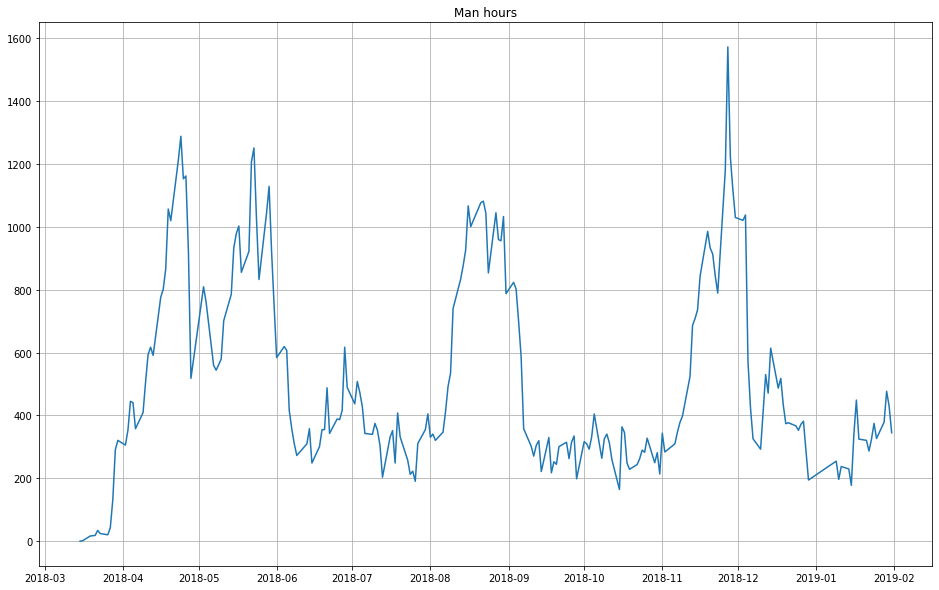

In [ ]:
# Посмотрим на график с исходными данными
plt.figure(figsize=(16,10))
plt.plot(dataset['manHours'])
plt.grid()
plt.title('Man hours')
plt.show()

Предположим, что всё то, что находится между 5 и 95 квантилями - хорошие данные. Всё остальное - выбросы.

In [ ]:
# Находим квантили
lower_bound = dataset['manHours'].quantile(0.05)
higher_bound = dataset['manHours'].quantile(0.95)

# Рубим квантили
new_df = dataset[(dataset['manHours'] > lower_bound.item()) & (dataset['manHours'] < higher_bound.item())]

Посмотрим, что у нас получилось

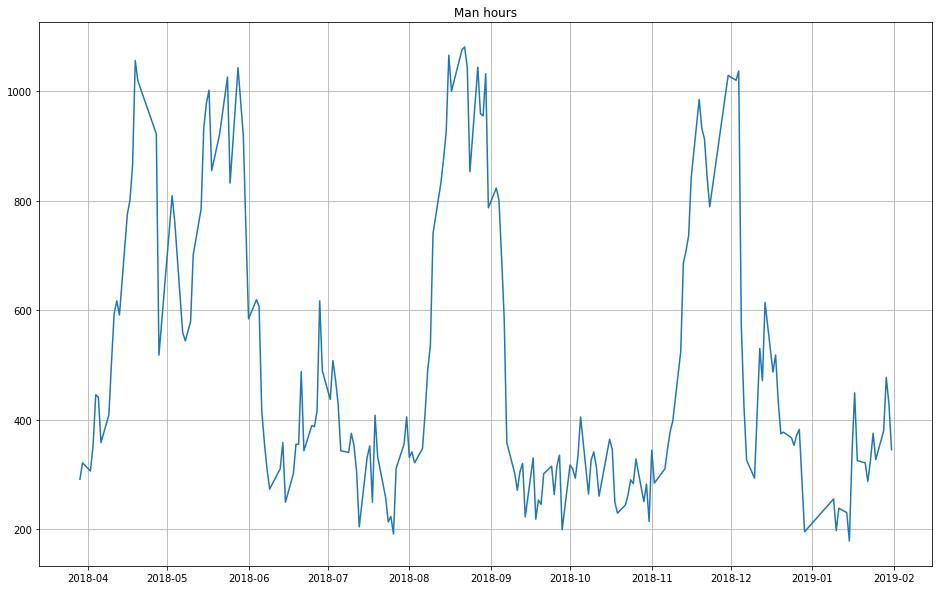

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(new_df['manHours'])
plt.grid()
plt.title('Man hours')
plt.show()

Попробуем воспользоваться тройным экспоненциальным сглаживанием или, что то же самое, методом Хольта-Винтерса.

In [ ]:
class HoltWinters:
    
    """
    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                
                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                
            
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])


            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])
                
                
                
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [ ]:
# Фу
def timeseriesCVscore(x):
    # вектор ошибок
    errors = []
    
    values = data.values
    alpha, beta, gamma = x
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 5*4, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)
    return np.mean(np.array(errors))

In [ ]:
%%time
data = new_df.manHours[:-20] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 1] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.08765473929168316 0.019333758474110674 0.6219942849640114
CPU times: user 3 s, sys: 4.69 ms, total: 3 s
Wall time: 3.03 s


In [ ]:
# Передаем оптимальные значения модели, 
data = new_df.manHours
model = HoltWinters(data[:-20], slen = 5*4, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 20, scaling_factor = 2.56)
model.triple_exponential_smoothing()

In [ ]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    print('metric %f' % bus_metric(data.values, model.result))
    plt.axvspan(len(data)-20, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

metric 104.592359


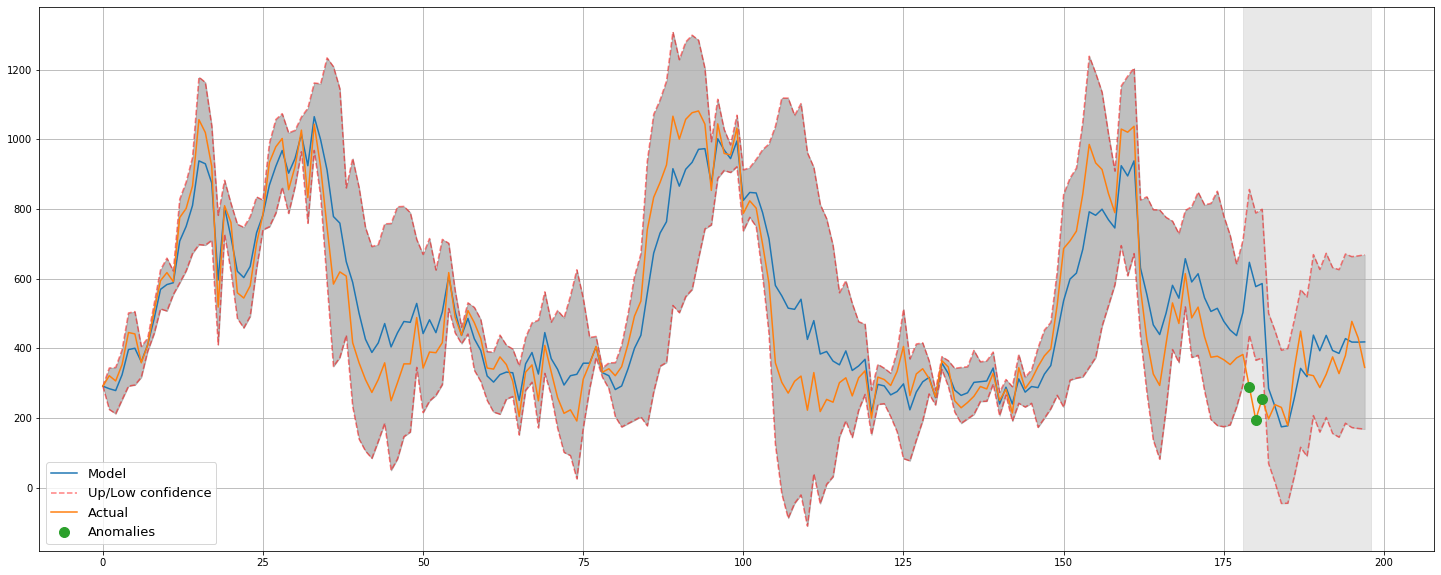

In [ ]:
plotHoltWinters()

Получив метрику 104 для моедли Хольта-Винтерса, идем дальше и смотрим, какая метрика получится для модели SARIMA. Для этого посмотрим на автокорреляцию временного ряда и критерий Дики-Фуллера (если он равен 0, то считаем, что мы можем построить SARIMA)

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])


        plt.tight_layout()
    return

Критерий Дики-Фуллера: p=0.056995


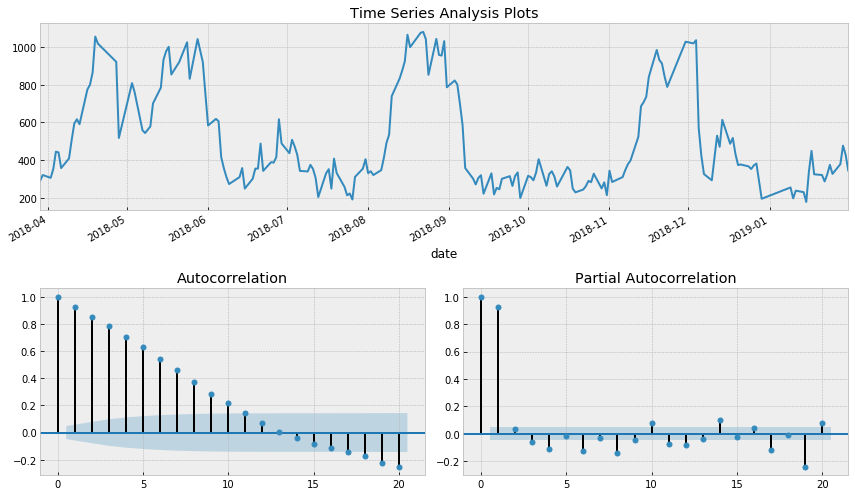

In [ ]:
tsplot(new_df.manHours, lags=20)

Критерий Дики-Фуллера: p=0.044640
Оптимальный параметр преобразования Бокса-Кокса: -0.469166


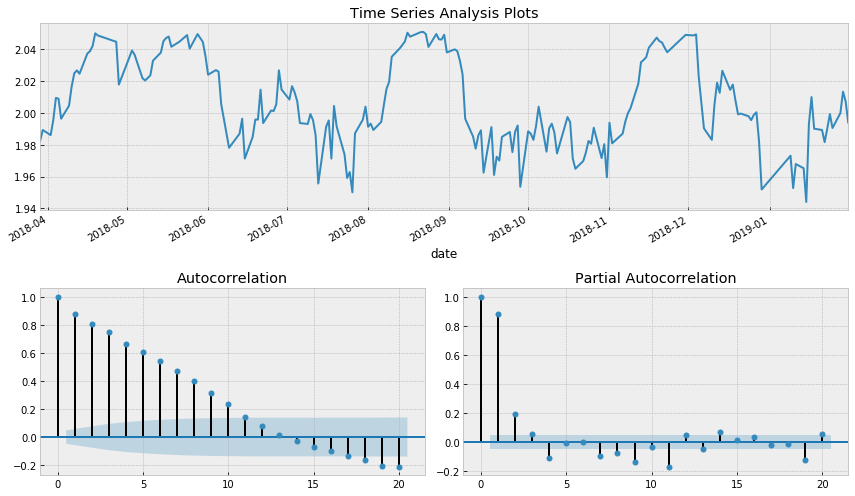

In [ ]:
def invboxcox(y,lmbda):
    # обратное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))


data = new_df.copy()
data['manHours_box'], lmbda = scs.boxcox(data.manHours) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data.manHours_box, lags=20)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Критерий Дики-Фуллера: p=0.000000


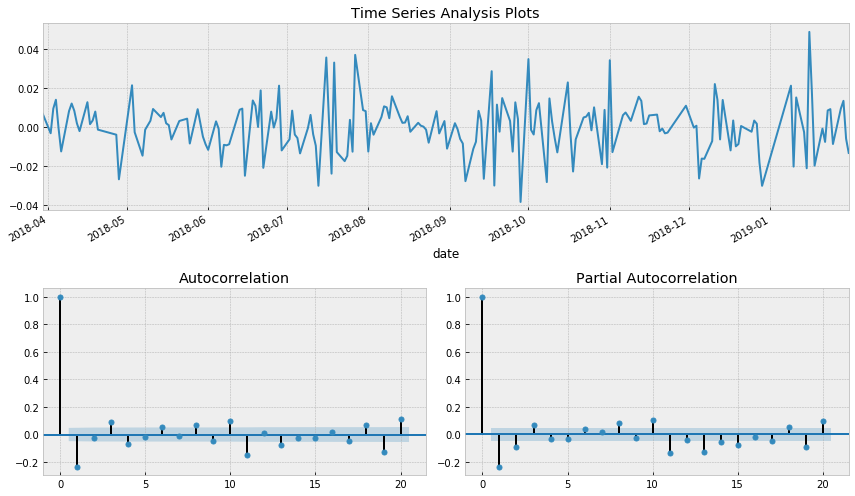

In [ ]:
data['manHours_season'] = data.manHours_box - data.manHours_box.shift(1)
data_SARIMA = data['manHours_season']
d
tsplot(data.manHours_season[1:].dropna(), lags=20)

D = 1
p = 3
q = 3

In [ ]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)



parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [ ]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data_SARIMA, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[3], D, param[3], 30)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
49  (2, 1, 4, 0) -817.178695
46  (2, 1, 1, 0) -817.178695
45  (2, 1, 0, 0) -817.178695
47  (2, 1, 2, 0) -817.178695
48  (2, 1, 3, 0) -817.178695
CPU times: user 6min 33s, sys: 4min 34s, total: 11min 7s
Wall time: 5min 39s


In [ ]:
%%time
best_model=sm.tsa.statespace.SARIMAX(data.manHours_box, order=(3, d, 3), 
                                        seasonal_order=(3, D, 1, 30)).fit(disp=-1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 4min 13s, sys: 55.7 s, total: 5min 9s
Wall time: 2min 36s


Критерий Дики-Фуллера: p=0.000000


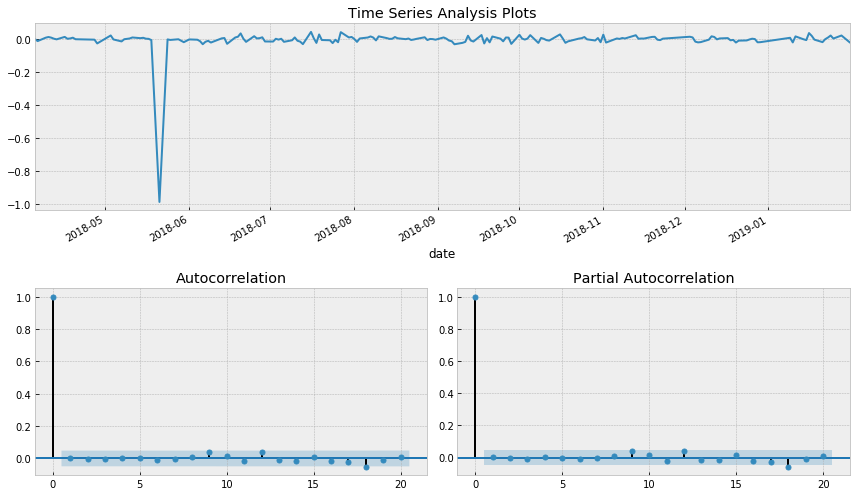

In [ ]:
tsplot(best_model.resid[5:], lags=20)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


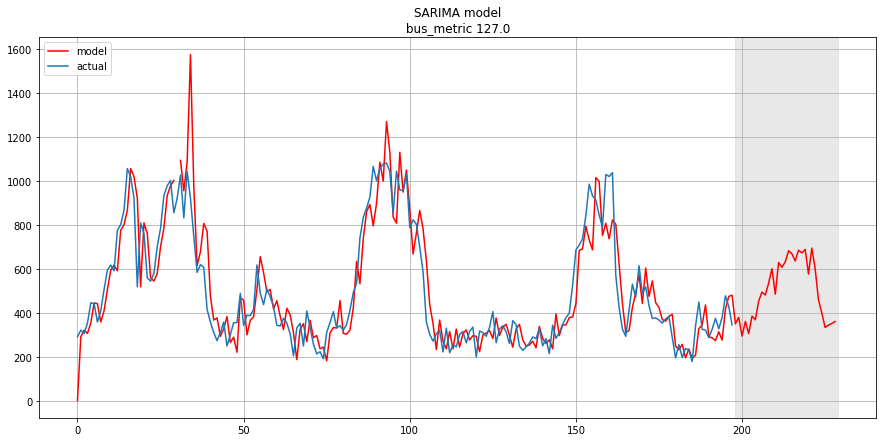

In [ ]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+30), lmbda)
forecast = data.arima_model.append(forecast).values
actual = data.manHours.values
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n bus_metric {} ".format(round(bus_metric(data.dropna().manHours, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

In [ ]:
print(forecast[-20:])

[600.19239756 484.69895835 628.63623401 607.15436671 630.8481509
 682.14855753 668.42425446 635.12667961 684.8435886  672.27338712
 688.19585813 576.50114004 694.14550286 601.18307787 459.59428422
 399.45449387 333.14991548 343.82868701 351.16519246 360.05258655]


Получив качество метрики на SARIMA равное 127, двигаемся дальше и попробуем построить линейную регрессию

In [ ]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [ ]:
data = pd.DataFrame(new_df.copy())

data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.head()

,manHours,hour,weekday,is_weekend
date,,,,
2018-03-29,291,0,3,0
2018-03-30,321,0,4,0
2018-04-02,306,0,0,0
2018-04-03,353,0,1,0
2018-04-04,445,0,2,0


In [ ]:
code_mean(data, 'weekday', "manHours")

{0: 515.5555555555555,
 1: 498.6388888888889,
 2: 491.07894736842104,
 3: 517.1904761904761,
 4: 496.90697674418607,
 5: 328.6666666666667}

In [ ]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
   
    data["weekday"] = data.index.weekday
    
    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))

    # выкидываем закодированные средними признаки 
    data.drop(["weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test

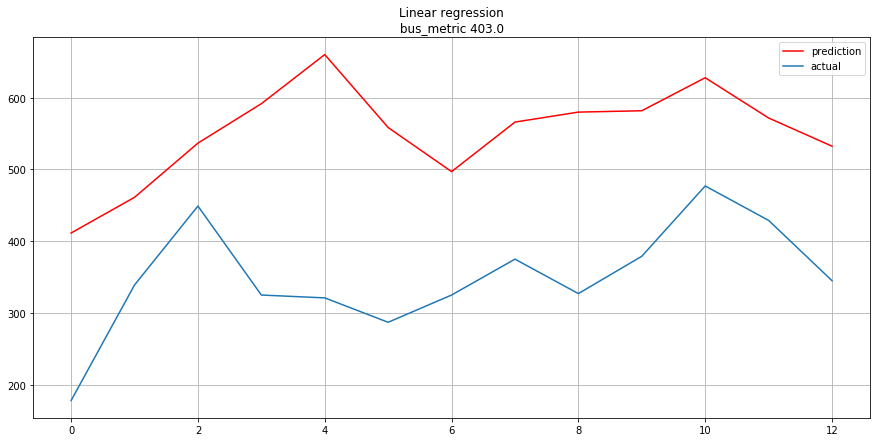

In [ ]:
X_train, X_test, y_train, y_test = prepareData(new_df.manHours, test_size=0.3, lag_start=12, lag_end=48)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n bus_metric {} ".format(round(bus_metric(prediction, y_test))))
plt.grid(True);

Получив  значение метрики равное 403 для линейной регрессии попробуем последнюю модель для прогнозирования временного ряда, а именно walk forward validation

In [ ]:
# модель walk forward validation
from math import sqrt
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from statistics import median

# делим данные на тестовую и обучающую выборки
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	agg = concat(cols, axis=1)
	agg.dropna(inplace=True)
	return agg.values

# датасет
def difference(data, interval):
	return [data[i] - data[i - interval] for i in range(interval, len(data))]

# фитим модель
def model_fit(train, config):
	return None

# прогноз
def model_predict(model, history, config):
	values = list()
	for offset in config:
		values.append(history[-offset])
	return median(values)

# walk-forward validation 
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	train, test = train_test_split(data, n_test)
	model = model_fit(train, cfg)
	history = [x for x in train]
	for i in range(len(test)):
		yhat = model_predict(model, history, cfg)
		predictions.append(yhat)
		history.append(test[i])
	# посмотрим нашу метрику
	error = bus_metric(test, predictions)
	print(' > %.3f' % error)
	return error

def repeat_evaluate(data, config, n_test, n_repeats=1):
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores

def summarize_scores(name, scores):
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f bus_metric (+/- %.3f)' % (name, scores_m, score_std))
	


series = new_df
data = series.values
# data split
n_test = 20
# define config
config = [20]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('persistence', scores)

 > 251.000
persistence: 251.000 bus_metric (+/- 0.000)


Сравнив метрики bus_metric по всем четырем моделям (403 для линейной регрессии, 251 для walk forward validation, 127 для SARIMA и 104 для Хольта-Винтерса), мы получили лучший результат у модели Хольта-Винтерса, соответственно, строим предсказание на февраль по данной модели. Однако экспоненциальное сглаживание в итоге дает предсказание, которое в точности повторяет последние данные. Поэтому мы обращаемся к второй по качеству модели - SARIMA и строим прогноз по ней (скачиваем данные в эксель, так как прогноз по SARIMA уже был построен выше).  

In [ ]:
# Передаем оптимальные значения модели, 
data = new_df.manHours
model = HoltWinters(data, slen = 5*4, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 20, scaling_factor = 2.56)
model.triple_exponential_smoothing()

In [ ]:
def plotHoltWinters():
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.axvspan(len(data), len(data)+20, alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

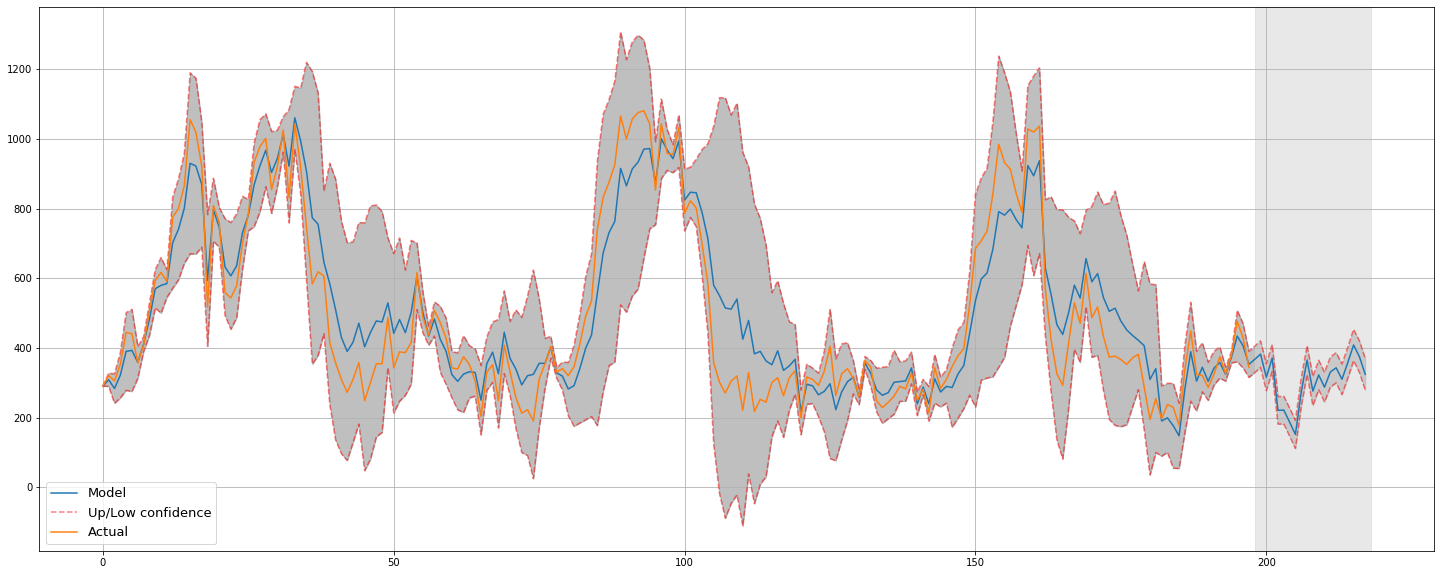

In [ ]:
plotHoltWinters()